In [13]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('ProstateCancer.csv')

#Drop the unrelated columns
df = df.drop(columns=['Unnamed: 0.1','Unnamed: 0'])

#Seperate the training and testing data
train_test_mask = df.pop('train')

#All responses
y = df.pop('lpsa')

#standardize data
df = (df- df.mean())/df.std()


df

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-1.637356,-2.006212,-1.862426,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467
1,-1.988980,-0.722009,-0.787896,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467
2,-1.578819,-2.188784,1.361163,-1.024706,-0.522941,-0.863171,0.342627,-0.155348
3,-2.166917,-0.807994,-0.787896,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467
4,-0.507874,-0.458834,-0.250631,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467
...,...,...,...,...,...,...,...,...
92,1.255920,0.577607,0.555266,-1.024706,1.892548,1.073572,0.342627,1.262889
93,2.096506,0.625489,-2.668323,-1.024706,1.892548,1.679542,0.342627,0.553770
94,1.321402,-0.543304,-1.593794,-1.024706,1.892548,1.890377,0.342627,-0.509907
95,1.300290,0.338384,0.555266,1.004813,1.892548,1.242632,0.342627,1.972007


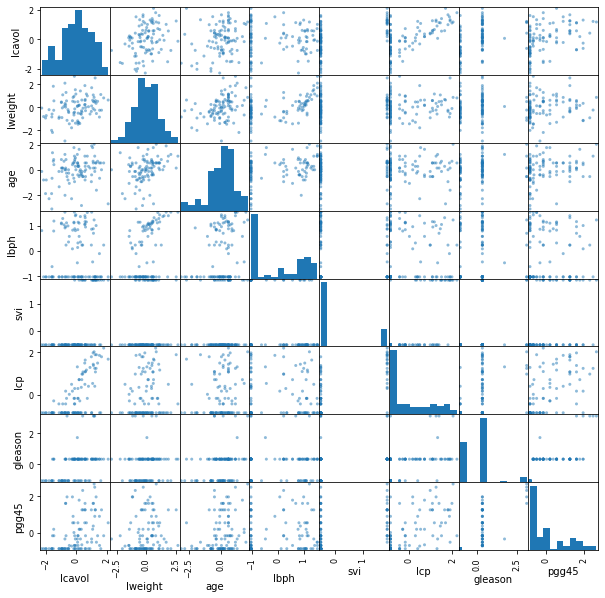

In [15]:
s = pd.plotting.scatter_matrix(df, figsize=(10.0,10.0))

In [16]:
#lcavol-lcp showing strong correlation, svi and gleason are categorical variables.
df.corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652
lweight,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354
age,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112
lbph,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460
svi,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648
lcp,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528
gleason,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905
pgg45,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000


In [17]:
#Get the predictors and responses
y_train = y[train_test_mask == 'T']
X_train = df[train_test_mask == 'T']

In [18]:
X_train.corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


In [32]:
class LinearRegression:
    def fit(self,x,y):
        
        self.x = x.to_numpy()
        self.y = y
        #add bias term to the input matrix
        self.x = np.hstack((np.ones((self.x.shape[0],1)),self.x))

        #incase of x being rank deficient: mostly result of redundant variables. Removing those can help...
        self.x_inv = np.linalg.inv(self.x.T@self.x)

        self.theta = self.x_inv@self.x.T@self.y

        #Unstandardized coefficient should not be used to drop as it does not eliminate the unit of measurement.
        #Unstandardized coefficients are not useful when comparing the variables to each other
        #Variance estimation
        self.var = np.sum((self.x @ self.theta - self.y)**2) / (self.x.shape[0]-self.x.shape[1])

        #standard error
        self.stnd_error = np.sqrt(np.diag(self.x_inv)) * np.sqrt(self.var)

        #Z scores of variables. Coefficient/standard error
        self.scores = self.theta/self.stnd_error


        return self.theta, self.stnd_error, self.scores
    
    def fitRidge(self,x,y,l):
        #shrinks the regression coefficients by imposing a penalty on their size
        self.x = x.to_numpy()
        self.y = y
        self.x = np.hstack((np.ones((self.x.shape[0],1)),self.x))
        
        #adds a positive constant to the diagonal, also makes the problem nonsingular
        self.x_inv = np.linalg.inv(self.x.T@self.x + l*np.eye(self.x.shape[1]))

        self.theta = self.x_inv@self.x.T@self.y
        
        return self.theta
    
    def predict(self,x,w):
        self.x = x.to_numpy()

        self.x = np.hstack((np.ones((self.x.shape[0],1)),self.x))

        return self.x@w

    def cost(self,x,w,y):
        #Least Square Cost
        self.x = x.to_numpy()
        self.x = np.hstack((np.ones((x.shape[0],1)),x))

        return (y-self.x@w).T@(y-self.x@w)
    
    

In [20]:
w, stnd_error ,scores = LinearRegression().fit(X_train,y_train)

In [21]:
#A roughly absoulute z score of 2 is significant at the %5 level
#We can consider dropping age, lcp, gleason, pgg45 by looking at F statistic
pd.DataFrame(data={'Coefficient': w, 'Stnd Error': stnd_error, 'Z Scores': scores },
            index= ['Intercept']+df.columns.tolist())

,Coefficient,Stnd Error,Z Scores
Intercept,2.464933,0.089315,27.598203
lcavol,0.679528,0.126629,5.366290
lweight,0.263053,0.095628,2.750789
age,-0.141465,0.101342,-1.395909
lbph,0.210147,0.102219,2.055846
svi,0.305201,0.123600,2.469255
lcp,-0.288493,0.154529,-1.866913
gleason,-0.021305,0.145247,-0.146681
pgg45,0.266956,0.153614,1.737840


In [22]:
costWithOutDrop = LinearRegression().cost(X_train,w,y_train)
costWithOutDrop

29.426384459908395

In [23]:
X_train_dropped = X_train.drop(columns=['age','lcp','gleason','pgg45'])
X_train_dropped

,lcavol,lweight,lbph,svi
0,-1.637356,-2.006212,-1.024706,-0.522941
1,-1.988980,-0.722009,-1.024706,-0.522941
2,-1.578819,-2.188784,-1.024706,-0.522941
3,-2.166917,-0.807994,-1.024706,-0.522941
4,-0.507874,-0.458834,-1.024706,-0.522941
...,...,...,...,...
90,1.609063,1.103786,-1.024706,-0.522941
91,1.003621,0.113497,0.860016,1.892548
92,1.255920,0.577607,-1.024706,1.892548
93,2.096506,0.625489,-1.024706,1.892548


In [25]:
theta_dropped, se,zs = LinearRegression().fit(X_train_dropped,y_train)
costWithDrop = LinearRegression().cost(X_train_dropped,theta_dropped,y_train)
costWithDrop

32.81499474881555

In [26]:
#(Pr(F 4,58 > 1.67) = 0.17)The p-value is .17, the result is not significant at p < .05. No need to drop.
foo = (costWithDrop-costWithOutDrop)/(X_train.shape[1]-X_train_dropped.shape[1])
F = foo/(costWithOutDrop/(X_train.shape[0] - X_train.shape[1]-1))
F

1.6697548846375236

In [27]:
#Testing
y_test = y[train_test_mask=='F']
x_test = df[train_test_mask=='F']

In [31]:
w,_,_ = LinearRegression().fit(X_train,y_train)
predict =LinearRegression().predict(x_test,w)
#Mean squared error
error = np.mean((y_test-predict)**2)
error

0.5212740055075998

In [29]:
#Base error reduced by %50
base = np.mean((y_test-np.mean(y_train))**2)
base

1.0567332280603818

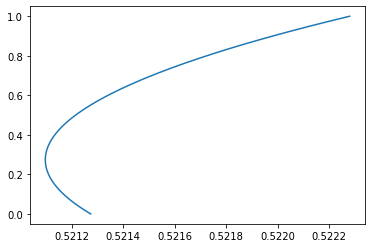

In [131]:
#Ridge regression with grid search

l = np.linspace(0,1,1000)
best_l = 100
bestError = 100
plot = []
for i in range(len(l)):
    w = LinearRegression().fitRidge(X_train,y_train,l[i])
    predict =LinearRegression().predict(x_test,w)
    error = np.mean((y_test-predict)**2)
    plot.append(error)
    if error<bestError:
        best_l = l[i]
        bestError = error

plt.plot(plot,l)